In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from hyperion.models.photon_arrival_time.pdf import make_gamma_exponential
from hyperion.models.photon_arrival_time.net import PhotonArivalTimePars
import pickle
import scipy.optimize
from torch.utils.data import DataLoader
from hyperion.utils import cherenkov_ang_dist, ANG_DIST_INT
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import torch.optim as optim
%matplotlib inline


from jax import numpy as jnp
from jax import value_and_grad, jit

In [110]:
def expon_pdf(x, a):
    return 1/a * jnp.exp(-x/a)


def make_exp_exp(data, weights):
    """
    Create a two-exponential mixture model pdf.

    This functions returns the likelihood evaluated on data and weights, and
    the likelihood function.

    Parameters:
        data: ndarray
        weights: ndarray

    """
    
    def func(xs, scale1, scale2, mix):
        lower = jnp.min(jnp.array([scale1, scale2])) * 100
        upper = jnp.max(jnp.array([scale1, scale2])) * 100
        
        """
        f1 = jnp.log(mix) + jnp.log(expon_pdf(xs, scale))
        f2 = jnp.log(1 - mix) + scipy.stats.expon.logpdf(xs, scale=scale2)
        stacked = np.vstack([f1, f2])

        res = scipy.special.logsumexp(stacked, axis=0)
        res[~np.isfinite(res)] = 1e4
        """
        
        res = jnp.log(mix * expon_pdf(xs, lower) + (1- mix) * expon_pdf(xs, upper))
        
        return res

    def obj(scale1, scale2, mix):
        val = -jnp.sum((func(data, scale1, scale2, mix) * weights))
        return val
  
    return  jit(value_and_grad(obj, [0, 1, 2])), func

def make_exp_exp_exp(data, data_weights):
    """
    Create a two-exponential mixture model pdf.

    This functions returns the likelihood evaluated on data and weights, and
    the likelihood function.

    Parameters:
        data: ndarray
        weights: ndarray

    """
    
    def func(xs, scale1, scale2, scale3, w1, w2, w3):
        
        scales = jnp.array([scale1, scale2, scale3]) * 100
        scales = jnp.sort(scales)
        
        wsum = w1 + w2 + w3
        weights = jnp.array([
            w1 / wsum, w2 / wsum, w3 / wsum])
        
        res = jnp.log(weights[0] * expon_pdf(xs, scales[0]) + weights[1] * expon_pdf(xs, scales[1]) + weights[2] * expon_pdf(xs, scales[2]))
        
        return res

    def obj(scale1, scale2, scale3, w1, w2, w3):
        val = -jnp.sum((func(data, scale1, scale2, scale3, w1, w2, w3) * data_weights))
        return val
  
    return jit(value_and_grad(obj, [0, 1, 2, 3, 4, 5])), func

def make_data(t, w, det_dist, thr=2):
    tgeo = t -((det_dist-r) / c_medium)
    mask = (tgeo  > thr)
    
    return tgeo[mask]-thr, w[mask], 1 - (w[mask].sum() / w.sum())

def fit(obj):
    best_res = None
    for _ in range(5):
       
        """
        seed = np.random.uniform(0, 1, size=3)
        res = scipy.optimize.fmin_l_bfgs_b(obj, seed, 
                                            bounds=((1E-3, None), (1E-3, None),  (1E-6, 1-1E-6)),
                                            factr=100,
                                            approx_grad=False)
                            
        """
        
        seed = np.random.uniform(0, 1, size=6)
        res = scipy.optimize.fmin_l_bfgs_b(obj, seed, 
                                            bounds=((1E-3, None), (1E-3, None), (1E-3, None),
                                                    (0, None), (0, None), (0, None)),
                                            factr=100,
                                            approx_grad=False)
        
        
        if res[2]["warnflag"] == 2:
            continue
        if (best_res is None) or res[1] < best_res[1]:
            best_res = res
    return best_res

def wrap(f):
    def _f(*pars):
        if len(pars) == 1:
            pars = pars[0]
        res = f(*pars)
        return np.array(res[0], order="F"), np.array(res[1], order="F")
    return _f

In [83]:
sca_len = 100
c_medium = 0.3 / 1.35
abs_len = 30
r = 0.21
det_ph = pickle.load(open("photon_table_0.pickle", "rb"))
#fit_pars = pickle.load(open("photon_fitpars_1.pickle", "rb"))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


(1e-10, 1)

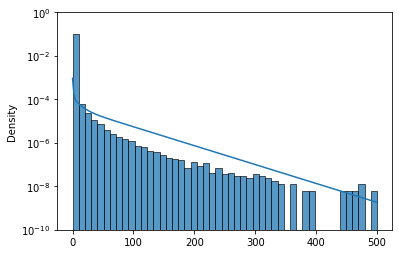

In [106]:
det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
weights = np.exp(-isec_times *c_medium / abs_len)
c_weight = cherenkov_ang_dist(np.cos(ph_thetas-0)) / ANG_DIST_INT *2
t, w, ucf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
obj, func = make_exp_exp_exp(t, w)
t, w, _ = make_data(isec_times, weights*c_weight, det_dist, thr=0)
sns.histplot(x=t, weights=w, bins=np.linspace(0, 500, 50), stat="density")
plt.semilogy()


xs = np.linspace(0, 500, 500)
plt.plot(xs, (1-ucf)*np.exp(func(xs, 0.5, 0.1, 0.01, 0.2, 0.2, 0.5)))
plt.ylim(1E-10, 1)

In [98]:
obj, func = make_exp_exp_exp(t, w)
func(t, 0.65954089, 0.00862261, 0.08710051, 1.2769194, 3.14159265)

[ 1.03983779e-09  3.43589164e-09 -1.00000000e+00]


DeviceArray([nan, nan, nan, ..., nan, nan, nan], dtype=float64)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

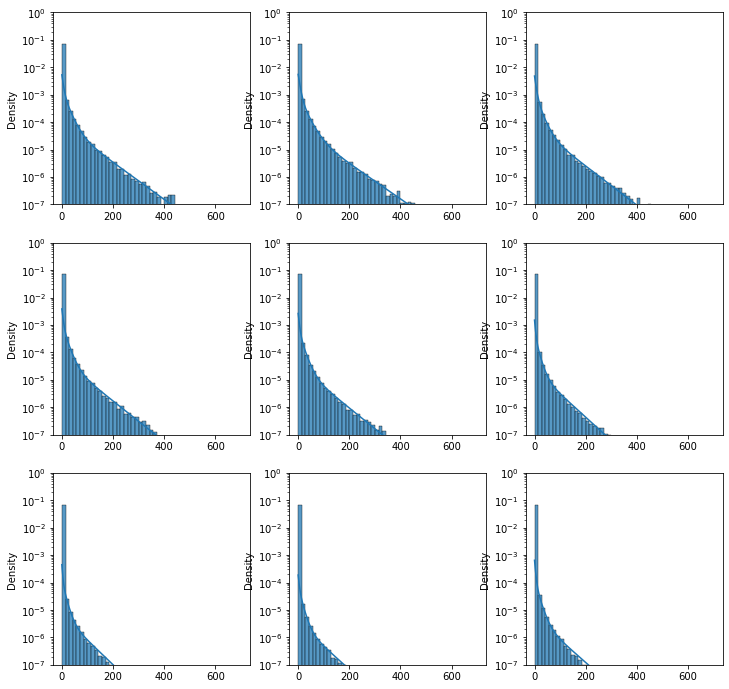

In [111]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

fit_results = []


thetas = np.arccos(np.linspace(-1, 1, 9))

for theta, ax in zip(thetas, axs.ravel()):
    
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / abs_len)
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, ucf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
    obj, func = make_exp_exp_exp(t, w)
    pars = fit(wrap(obj))
    t, w, _ = make_data(isec_times, weights*c_weight, det_dist, thr=0)
    sns.histplot(x=t, weights=w, bins=np.linspace(0, 700, 50), stat="density", ax=ax)
    plt.semilogy()

    
    xs = np.linspace(0, 700, 500)
    ax.plot(xs, (1-ucf)*np.exp(func(xs, *pars[0])))
    #plt.plot(xs, np.exp(lhfunc(xs, [1.5, 1, 1, 0.5])))
    #plt.semilogy()
    ax.set_ylim(1E-7, 1)
    ax.set_yscale("log")




In [43]:
wrap(obj)(0.5, 0.6, 0.1)

(array(3015.00709458), array([ -25.91597426, -280.95017541,   28.44688974]))

NameError: name 'jnp' is not defined

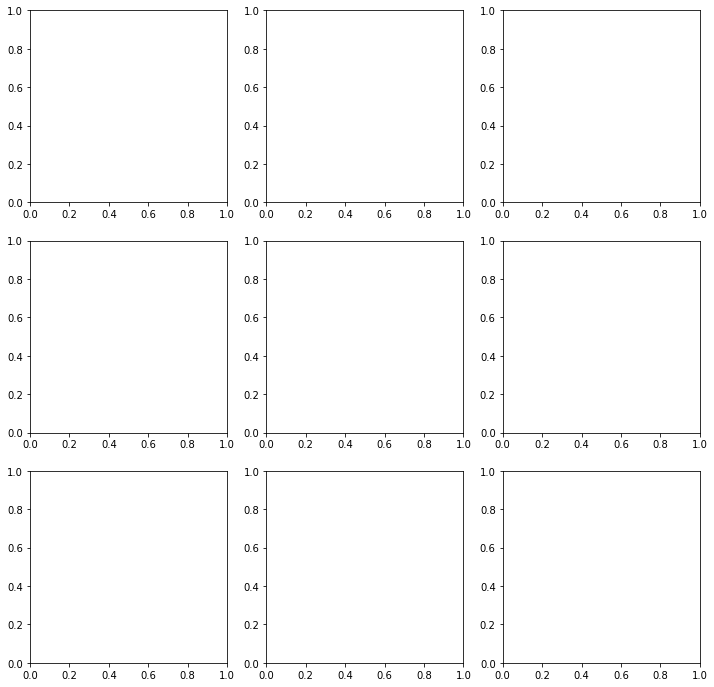

In [42]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

fit_results = []


for i, ax in zip(range(9), axs.ravel()):
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[i]
    weights = jnp.exp(-isec_times *c_medium / abs_len)
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-np.radians(30))) / ANG_DIST_INT *2
    t, w, ucf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
    best_res, func = fit(t, w)
    
    t, w, _ = make_data(isec_times, weights*c_weight, det_dist, thr=0)
    sns.histplot(x=t, weights=w, bins=np.linspace(0, 700, 50), stat="density", ax=ax)
    plt.semilogy()

    
    xs = np.linspace(0, 700, 500)
    ax.plot(xs, (1-ucf)*np.exp(func(xs, best_res[0])))
    #plt.plot(xs, np.exp(lhfunc(xs, [1.5, 1, 1, 0.5])))
    #plt.semilogy()
    ax.set_ylim(1E-7, 1)
    ax.set_yscale("log")
    fit_results.append(best_res[0])





/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


TypeError: 'NoneType' object is not subscriptable

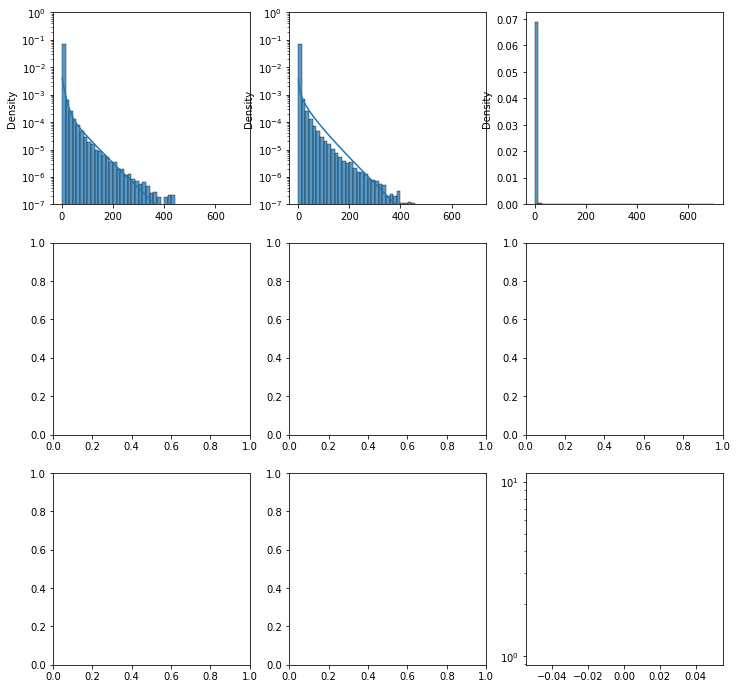

In [43]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

fit_results = []

thetas = np.arccos(np.linspace(-1, 1, 9))

for theta, ax in zip(thetas, axs.ravel()):
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / abs_len)
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
    best_res, func = fit(t, w)
    
    t, w, _ = make_data(isec_times, weights*c_weight, det_dist, thr=0)
    sns.histplot(x=t, weights=w, bins=np.linspace(0, 700, 50), stat="density", ax=ax)
    plt.semilogy()

    xs = np.linspace(0, 700, 500)
    ax.plot(xs, (1-usf)*np.exp(func(xs, best_res[0])))
    #plt.plot(xs, np.exp(lhfunc(xs, [1.5, 1, 1, 0.5])))
    #plt.semilogy()
    ax.set_ylim(1E-7, 1)
    ax.set_yscale("log")
    fit_results.append(best_res[0])
                 





In [29]:
np.degrees(np.arccos(1 / 1.35))

42.205446403732296

In [5]:
fit_results = []
rstate = np.random.RandomState(0)
for i in trange(50):
    thetas = np.arccos(rstate.uniform(-1, 1, 100))
    thetas = np.concatenate([
        thetas,
        [np.arccos(1 / 1.35) - 0.01, np.arccos(1 / 1.35), np.arccos(1 / 1.35) + 0.01],
    ]
    )
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[i]
    weights = jnp.exp(-isec_times *c_medium / abs_len)
    for theta in tqdm(thetas, total=len(thetas), leave=False):
        c_weight = cherenkov_ang_dist(jnp.cos(ph_thetas-theta)) / ANG_DIST_INT *2
        t, w, ucf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
        best_res, func = fit(t, w)    
        
        totw = weights*c_weight
        surv_frac = totw.sum() / (1E7*200)
   
        fit_results.append({"input": [theta, det_dist], "output": list(best_res[0]) + [ucf, surv_frac]})
pickle.dump(fit_results, open("data/arrival_time_pdf_pars.pickle", "wb"))

In [2]:
class MeanStdScaler:
    def __init__(self, data):
        self._means = np.mean(data, axis=0)
        self._stds = np.std(data, axis=0)
        
    def scale(self, data):
        return (data - self._means) / self._stds
    
    def unscale(self, data):
        return data * self._stds + self._means

In [3]:
fit_results = pickle.load(open("combined_photon_fitpars.pickle", "rb"))
data = []
for d in fit_results:
    data.append(list(d["input"]) + list(d["output"]))
data = np.asarray(np.vstack(data).squeeze(), dtype=np.float32)

data[:, 1] = np.log10(data[:, 1])
data[:, -1] = np.log10(data[:, -1])
input_scaler = MeanStdScaler(data[:, :2])
output_scaler = MeanStdScaler(data[:, 2:])
data[:, :2] = input_scaler.scale(data[:, :2])
data[:, 2:] = output_scaler.scale(data[:, 2:])

In [5]:
X = []
y = []
for d in fit_results:
    X.append(d["input"])
    y.append(d["output"])
    
X = np.asarray(X)
y = np.asarray(y)


cls = autoPyTorch.AutoNetRegression()

AttributeError: module 'autoPyTorch' has no attribute 'api'

In [23]:
data

tensor([[ 1.7792, -0.0259,  1.8767,  ..., -0.1587, -0.3914,  0.0670],
        [ 0.0420, -0.6551,  0.6190,  ..., -0.4579,  0.5613,  0.6320],
        [-0.2663,  0.3571,  0.4397,  ..., -0.0803, -0.2435,  0.0406],
        ...,
        [ 1.7803,  1.0683,  1.8767,  ..., -0.8103, -1.2585, -1.1978],
        [-0.7086,  0.5212, -1.0218,  ...,  1.1284,  0.1036, -0.0122],
        [ 0.1081, -1.8587, -1.8111,  ...,  1.1284,  1.2079,  1.2449]])

,0,1,2,3,4,5,6,7
0,1.779188,-0.025922,1.876724,-0.010443,0.982662,-0.158709,-0.391404,0.066982
1,0.041966,-0.655098,0.618979,-0.023443,-0.393890,-0.457942,0.561299,0.632039
2,-0.266303,0.357054,0.439674,-0.006945,-0.365150,-0.080272,-0.243505,0.040636
3,-0.559762,1.314495,1.085672,-0.007540,-1.194598,0.201394,-1.496746,-1.432946
4,0.917676,1.177717,-0.872914,0.024971,1.397705,1.128425,-1.528787,-1.334798
...,...,...,...,...,...,...,...,...
251,1.094275,1.150362,0.156363,0.026121,1.278499,1.128425,-1.568726,-1.292673
252,-0.964556,-0.408898,-0.328144,-0.027423,-1.178660,0.215343,1.109876,0.781146
253,1.780322,1.068296,1.876724,0.030433,-0.746888,-0.810322,-1.258480,-1.197806
254,-0.708561,0.521187,-1.021785,-0.016773,1.036364,1.128425,0.103640,-0.012246


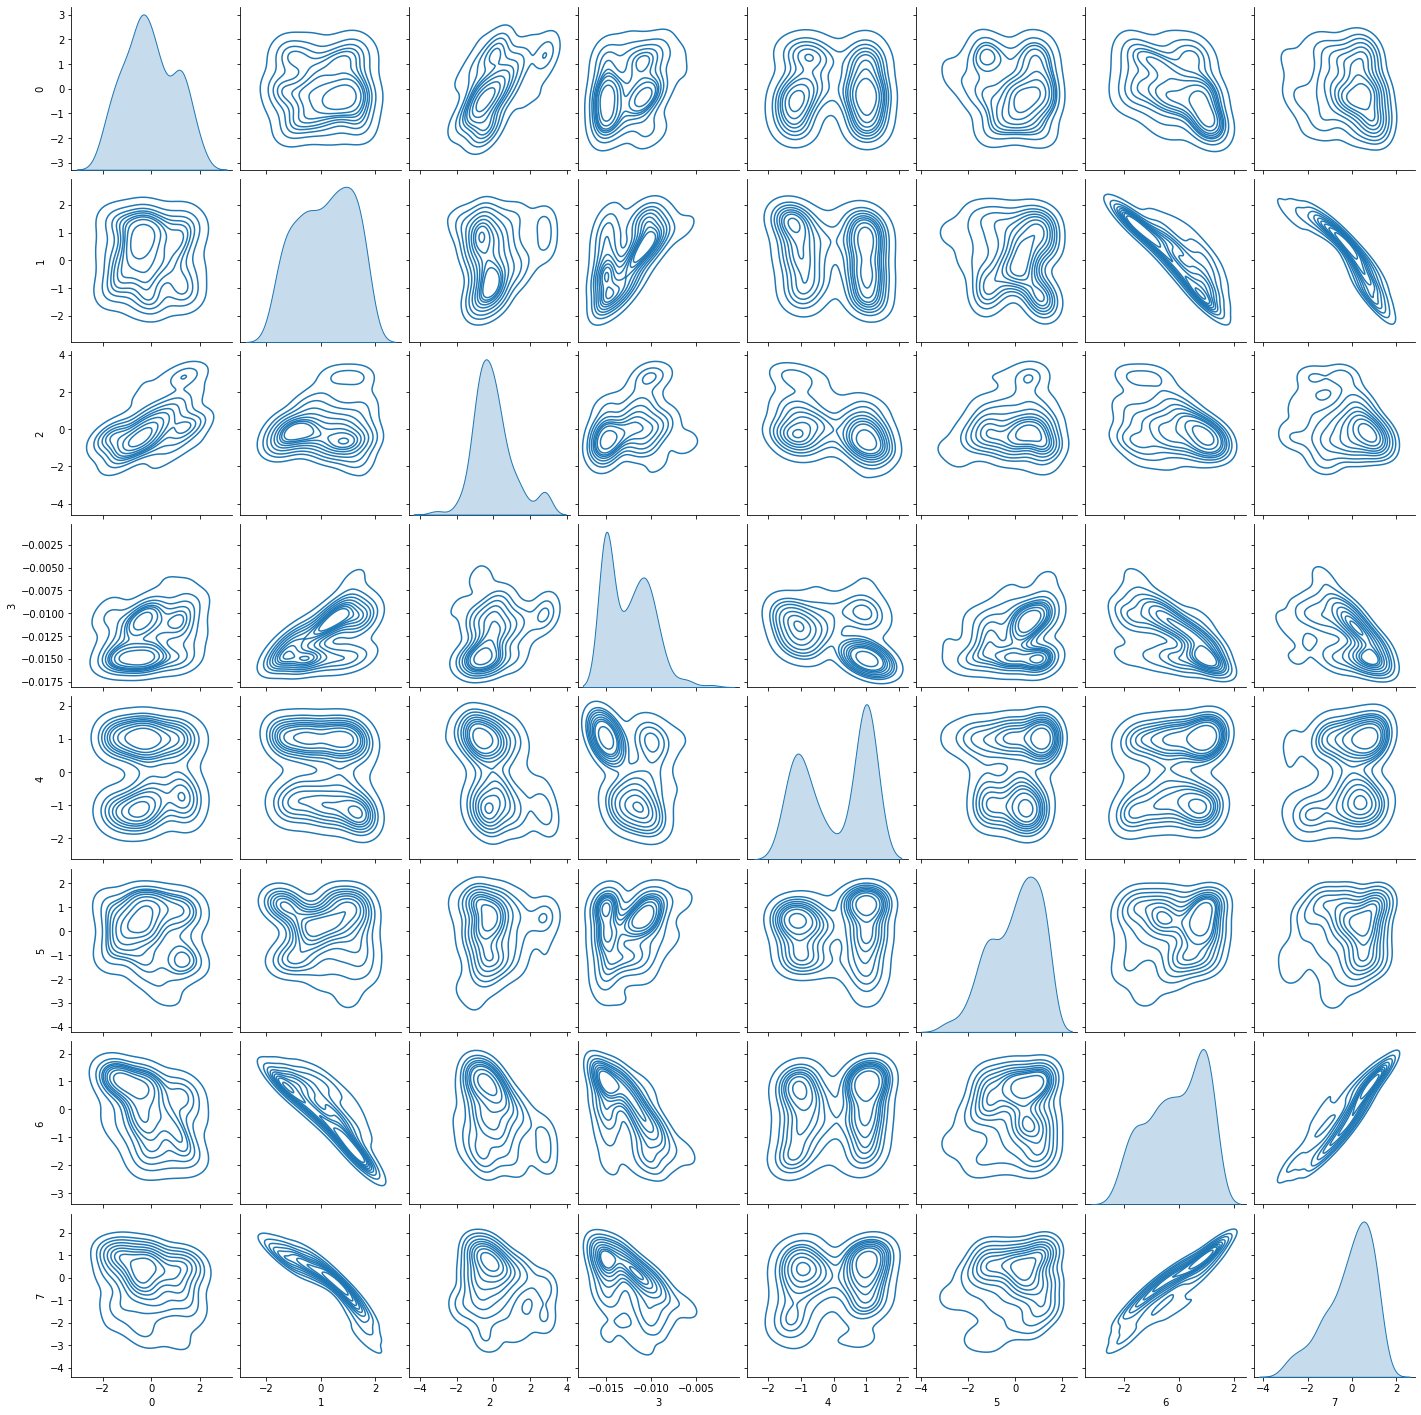

In [49]:
import pandas as pd
sns.pairplot(pd.DataFrame(np.asarray(data)), kind="kde")

In [4]:
rstate = np.random.RandomState(0)
indices = np.arange(len(data))
rstate.shuffle(indices)


data_shuff = data[indices]

split = int(0.5*len(data))
print(split)

g = torch.Generator()
torch.random.manual_seed(31337)
g.manual_seed(31337)



6282


In [5]:
conf = {
    "epochs": 2000,
    "batch_size": 200,
    "lr": 0.005,
}
writer = SummaryWriter(f"/tmp/tensorboard/runs/500_300_200_{conf['epochs']}_{conf['batch_size']}_{conf['lr']}")



train_data = torch.tensor(data_shuff[:split])
test_data = torch.tensor(data_shuff[split:])

train_loader = DataLoader(
    train_data,
    batch_size=conf["batch_size"],
    shuffle=True,
    #worker_init_fn=seed_worker,
    generator=g,
)
test_loader = DataLoader(
    test_data,
    batch_size=conf["batch_size"],
    shuffle=False,
    #worker_init_fn=seed_worker,
    generator=g,
)


In [40]:

# create your optimizer
net = PhotonArivalTimePars([500, 500, 300], 2, 6, dropout=0.5)
optimizer = optim.Adam(net.parameters(), lr=conf["lr"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, conf["epochs"])


def criterion(pred, target):
    #print(pred.shape, target.shape)
    #return torch.mean((pred - target)**2, axis=0)
    return torch.mean((pred - target)**2)

for epoch in range(conf["epochs"]):
    total_train_loss = 0
    for train in train_loader:
        net.train()
        optimizer.zero_grad()
        inp = train[:, :2]
        out = train[:, 2:]
        pred = net(inp)
        
        loss = criterion(pred, out)
        loss = loss.sum()
        loss.backward()

        total_train_loss += loss.item() * train.shape[0]

        optimizer.step()
    
    total_train_loss /= train_data.shape[0]

    total_test_loss = 0
    for test in test_loader:
        net.eval()

        inp = test[:, :2]
        out = test[:, 2:]
        pred = net(inp)
        
        loss = criterion(pred, out)
        loss = loss.sum()
        
      
        total_test_loss += loss.item() * test.shape[0]

    total_test_loss /= test_data.shape[0]
    
    writer.add_scalar("Loss/train", total_train_loss, epoch)
    writer.add_scalar("Loss/test", total_test_loss, epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]["lr"], epoch)
    
    scheduler.step()
    
    
    #scheduler.step(total_test_loss)
    if epoch % 50 == 0:
        print(f"epoch: {epoch}, train: {total_train_loss}, test: {total_test_loss}")


net.eval()
inp = test_data[:, :2]
out = test_data[:, 2:]
pred = net(inp)
loss = criterion(pred, out)
loss = loss.sum()
        
        
writer.add_hparams(conf, {"hparam/accuracy": loss})
writer.flush()
writer.close()
        

epoch: 0, train: 0.6058284918884683, test: 0.7409732289107048
epoch: 50, train: 0.4461624953007478, test: 0.6930885293308393
epoch: 100, train: 0.43407797850419366, test: 0.6848485309942556
epoch: 150, train: 0.42838061396690813, test: 0.6813229522918373
epoch: 200, train: 0.42666967353104257, test: 0.67840035870287
epoch: 250, train: 0.42415743324264, test: 0.6749310454852412
epoch: 300, train: 0.42164048529741527, test: 0.6733786443907226
epoch: 350, train: 0.41854663194649083, test: 0.6731423948343223
epoch: 400, train: 0.42160309544227487, test: 0.674640205512947
epoch: 450, train: 0.4190201187391867, test: 0.6727630191170384
epoch: 500, train: 0.4189689069730163, test: 0.6721207760997883
epoch: 550, train: 0.4184027648643869, test: 0.6735731688930289
epoch: 600, train: 0.42105781282448, test: 0.6769529104859007
epoch: 650, train: 0.41522654861600794, test: 0.6717124366809593
epoch: 700, train: 0.4182460051515003, test: 0.6735496433610105
epoch: 750, train: 0.41756611389743414, tes

In [37]:
torch.save(net, "data/arival_time_pars_net.dat")

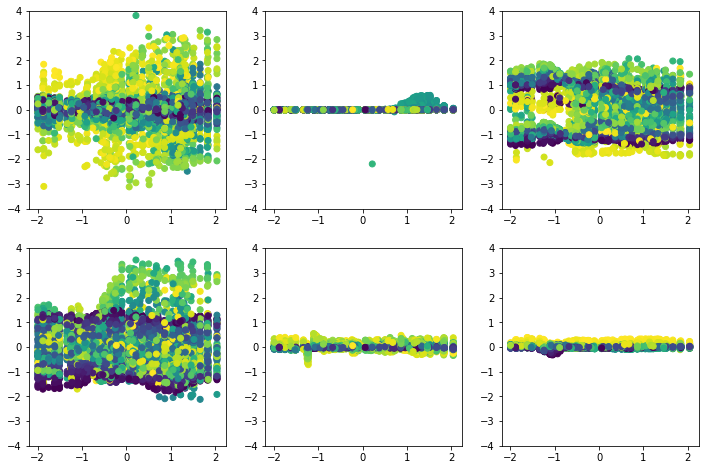

In [41]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axs.ravel()):
    ax.scatter(test_data[:, 0], net(test_data[:, :2]).detach()[:, i]-test_data[:, 2+i].detach(), c=test_data[:, 1])
    ax.set_ylim(-4, 4)


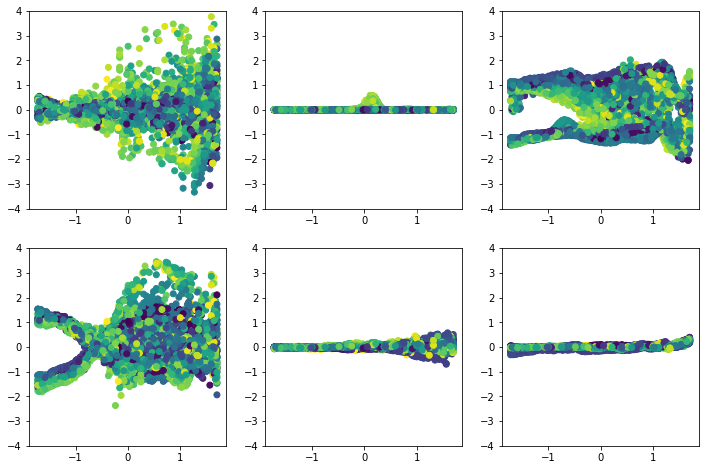

In [43]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axs.ravel()):
    ax.scatter(train_data[:, 1], net(train_data[:, :2]).detach()[:, i]-train_data[:, 2+i].detach(), c=train_data[:, 0])
    ax.set_ylim(-4, 4)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

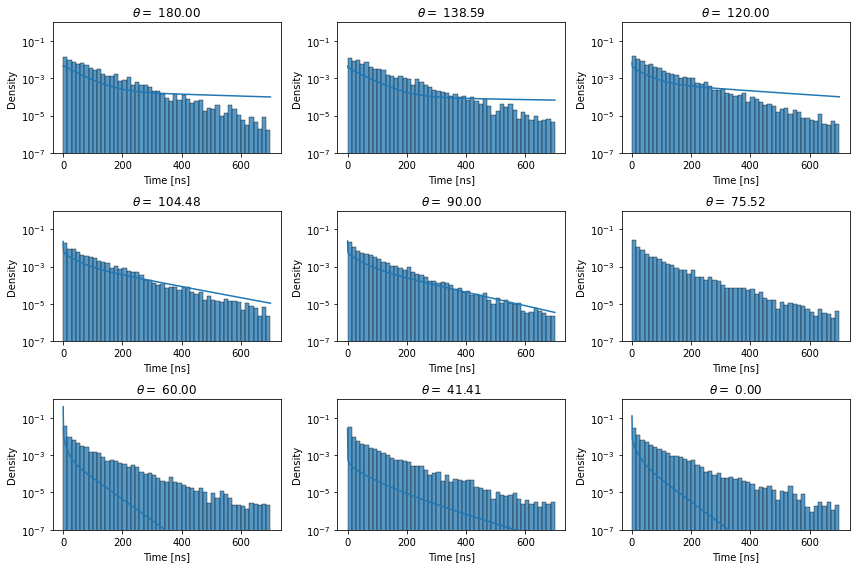

In [47]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

thetas = np.arccos(np.linspace(-1, 1, 9))

for theta, ax in zip(thetas, axs.ravel()):
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / abs_len)
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
    obj, func = make_gamma_exponential(t, w)
    scaled_inp = input_scaler.scale([[theta, np.log10(det_dist)]])
    pars = net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
    pars = output_scaler.unscale(pars)
    sns.histplot(x=t, weights=w, bins=np.linspace(0, 700, 50), stat="density", ax=ax)
    plt.semilogy()

    xs = np.linspace(1E-4, 700, 500)
    ax.plot(xs, (1-pars[-2])*np.exp(func(xs, pars[:-2])))

    ax.set_ylim(1E-7, 1)
    ax.set_yscale("log")
    ax.set_title(fr"$\theta =$ {np.degrees(theta):.2f}")
    ax.set_xlabel("Time [ns]")

                 
plt.tight_layout()




/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

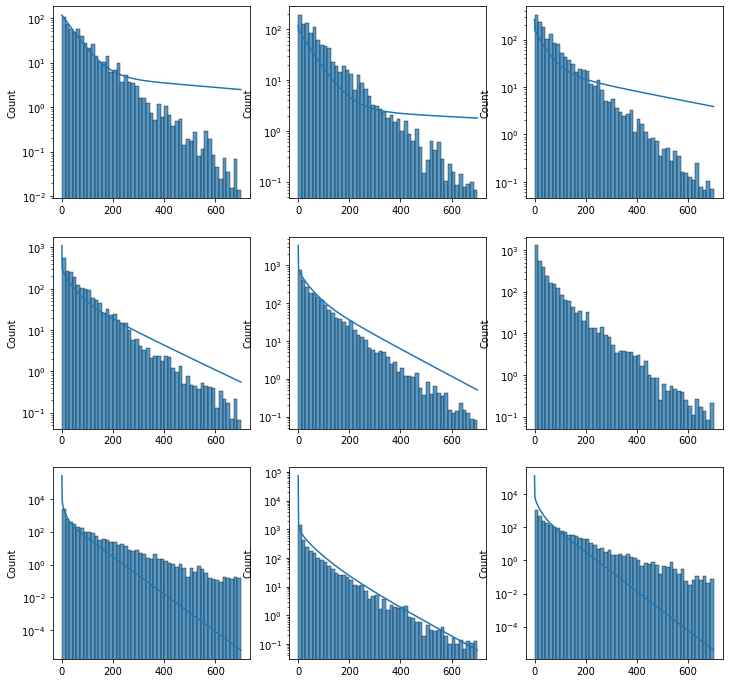

In [48]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

thetas = np.arccos(np.linspace(-1, 1, 9))

tbins = np.linspace(0, 700, 50)
net.eval()
for theta, ax in zip(thetas, axs.ravel()):
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / abs_len)
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
    obj, func = make_gamma_exponential(t, w)
    scaled_inp = input_scaler.scale([[theta, np.log10(det_dist)]])
    pars = net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
    #pars_amp  = net_amp(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
    #pars = output_scaler.unscale(torch.cat([pars, pars_amp]))
    pars = output_scaler.unscale(pars)
    sns.histplot(x=t, weights=w, bins=tbins, stat="count", ax=ax)
    plt.semilogy()

    dx = np.diff(tbins)[0]
    xs = np.linspace(1E-4, 700, 500)
    ax.plot(xs, dx * 10**pars[-1]*300*1E7*(1-pars[-2])*np.exp(func(xs, pars[:-2])))

    #ax.set_ylim(1E-3, 1E4)
    ax.set_yscale("log")

                 





In [113]:
scaled_inp = input_scaler.scale([[0, np.log10(2)]])
pars = output_scaler.unscale(net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach())
print(pars)

tensor([ 0.6443,  0.5157,  0.1314,  0.4749,  1.0260, -2.5546])


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

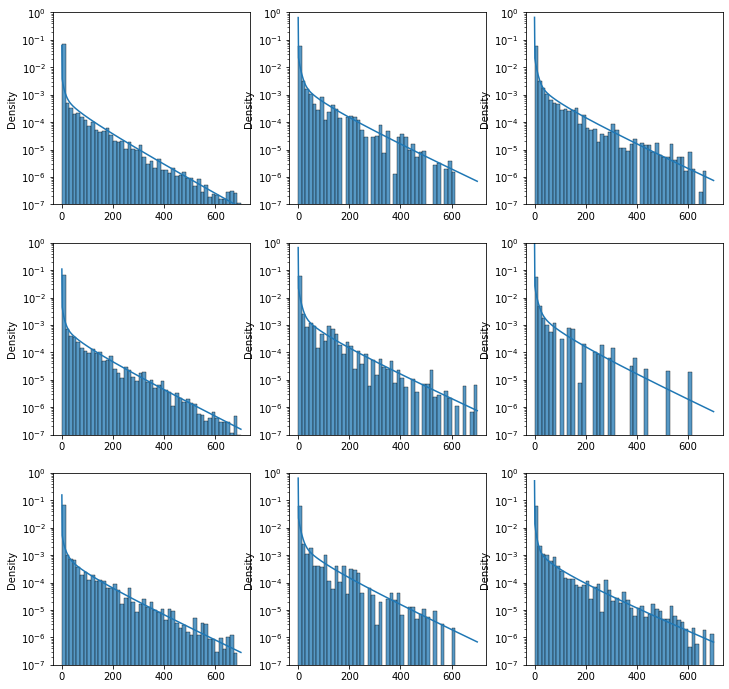

In [28]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
theta = np.radians(30)
for i, ax in zip(range(9), axs.ravel()):
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[i]
    weights = jnp.exp(-isec_times *c_medium / abs_len)
    c_weight = cherenkov_ang_dist(jnp.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, thr=0)
    obj, func = make_gamma_exponential(t, w)
    pars = scaler.unscale(net(torch.tensor([[theta, det_dist]], dtype=torch.float32))[0].detach())
    
    sns.histplot(x=t, weights=w, bins=np.linspace(0, 700, 50), stat="density", ax=ax)
    plt.semilogy()

    xs = np.linspace(1E-4, 700, 500)
    ax.plot(xs, (1-pars[-2])*np.exp(func(xs, pars[:-2])))

    ax.set_ylim(1E-7, 1)
    ax.set_yscale("log")
             





In [104]:
from numba import float64, jit
from numba.experimental import jitclass
import numpy as np

def make_generate_photons_nn(model, model_path):
    import torch

    torch.load(model, model_path)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    def generate_photons_nn(
        module_coords,
        module_efficiencies,
        sources,
        photocathode_area=Constants.photocathode_area,
        seed=31337,
    ):

        all_times_det = []
        np.random.seed(seed)

        source_pos = np.empty(len(sources))
        source_amp = np.empty(len(sources))
        source_dir = np.empty(len(sources))

        for i in range(len(sources)):
            source_pos[i] = sources[i].pos
            source_amp[i] = sources[i].amp
            source_dir[i] = sources[i].dir

        source_targ_vec = module_coords[np.newaxis, ...] - source_pos[:, np.newaxis, :]

        dist = np.linalg.norm(source_targ_vec, axis=-1)
        angles = np.arccos(
            np.einsum(
                "abk, ijk -> aj",
                source_dir[:, np.newaxis, :],
                source_targ_vec,
            )
            / dist
        )

        pdf_params = (
            model(torch.stack([angles.ravel(), dist.ravel()]))
            .numpy()
            .reshape(angles.shape)
        )

        @jit(nopython=True)
        def sample_times(pdf_params, sources, module_coords, module_efficiencies):

            all_times_det = []
            for idom in range(module_coords.shape[0]):

                this_times = []
                total_length = 0
                for isource in len(sources):
                    pars = pdf_params[idom, isource]

                    mix = pars[3]
                    usf = pars[4]
                    surv_rate = pars[5]

                    n_ph_tot = np.random.poisson(
                        surv_rate * sources[isource].amp * module_efficiencies[idom]
                    )
                    n_direct, n_indirect = np.random.multinomial(
                        n_ph_tot, [usf, 1 - usf]
                    )
                    n_gamma, n_exp = np.random.multinomial(n_indirect, [mix, 1 - mix])

                    times_det = np.emtpy(n_ph_tot)

                    times_det[:n_direct] = np.random.uniform(0, 2, size=n_direct)
                    times_det[n_direct : n_direct + n_gamma] = np.random.gamma(
                        pars[0], pars[1] * 100, size=n_gamma
                    )
                    times_det[
                        n_direct + n_gamma : n_direct + n_gamma + n_exp
                    ] = np.random.exponential(pars[2] * 100, size=n_exp)

                    this_times.append(times_det)
                    total_length += n_ph_tot

                this_times_arr = np.empty(total_length)
                i = 0
                for tt in this_times:
                    this_times_arr[i : i + tt.shape[0]] = tt  # noqa: E203
                    i += tt.shape[0]

                all_times_det.append(this_times_arr)

            return all_times_det

        all_times_det = sample_times(
            pdf_params, sources, module_coords, module_efficiencies
        )

        return all_times_det

    return generate_photons_nn

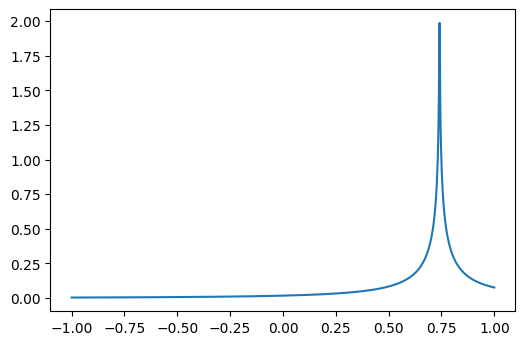

In [2]:
ct = jnp.linspace(-1, 1, 1000)
plt.plot(ct, cherenkov_ang_dist(ct))
a = 4.27033
d = -0.00103
maxval = a - d

In [3]:
fp = np.memmap("photons.dat", dtype="float32", mode="r", shape=(int(1e7), 15, 4))
fpd = np.memmap("photon_dirs.dat", dtype="float32", mode="r", shape=(int(1e7), 3))

In [4]:
theta = np.arccos(1/1.35)
costheta = np.cos(theta)
r = 10

target_x = sph_to_cart(theta, r)
target_r = 0.3

all_t = []
all_w = []

key = random.PRNGKey(0)

nph = int(1E6)
for i in range(10):
    key, subkey = random.split(key)
    isec_times, isec, weights = calc_intersections(fp[nph*i:(i+1)*nph, :, :3], fp[nph*i:(i+1)*nph, :, 3], target_x, target_r, 30, 100 / 90)
    tph = jnp.arccos(fpd[nph*i:(i+1)*nph, 2][jnp.any(isec, axis=1)])
    c_weight = cherenkov_ang_dist(jnp.cos(tph-theta)) / maxval
    all_t.append(isec_times)
    all_w.append(weights*c_weight)
all_t = np.concatenate(all_t)
all_w = np.concatenate(all_w)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


[]

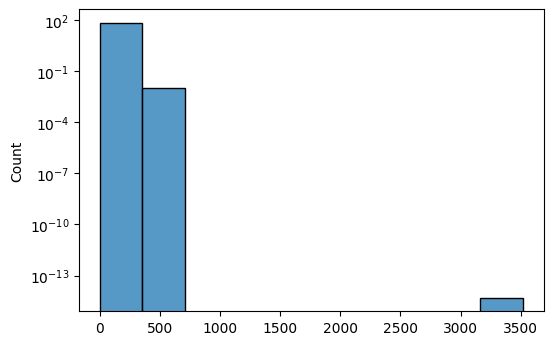

In [5]:
sns.histplot(x=all_t, weights=all_w)
plt.semilogy()

(10, 15)


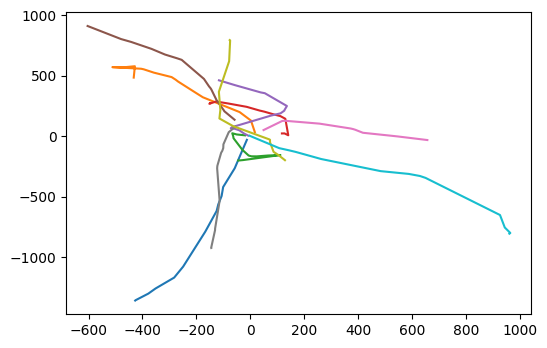

In [55]:
c_medium = 0.3 / 1.35
abs_len = 30
cnt= 10
weights = c_medium * jnp.cumsum(fp[:cnt, :, 3], axis=1) / abs_len 
print(weights.shape)
tph = jnp.arccos(fpd[:cnt, 2])[:, np.newaxis]
weights += jnp.log(cherenkov_ang_dist(jnp.cos(tph-theta)) / maxval)
plt.plot(fp[:cnt, :, 0].T, fp[:cnt, :, 1].T, )#color="k", alpha=0.3);
#plt.scatter(fp[:cnt, :, 0].T, fp[:cnt, :, 1].T, s=10, c=weights)

In [41]:
weights

DeviceArray([[1.56359270e-03, 8.22196063e-03, 2.00255346e-02, ...,
              4.41593230e-01, 5.06838322e-01, 5.72282612e-01],
             [7.41667524e-02, 4.49892193e-01, 9.93589997e-01, ...,
              9.73245049e+00, 1.09010391e+01, 1.21415501e+01],
             [3.92781764e-01, 1.52259445e+00, 2.67169333e+00, ...,
              5.65068169e+01, 6.61603012e+01, 7.60157776e+01],
             ...,
             [3.52552459e-02, 2.08424270e-01, 5.51545143e-01, ...,
              1.09529743e+01, 1.29722805e+01, 1.49930649e+01],
             [1.21581249e-01, 2.84927815e-01, 4.49799180e-01, ...,
              3.47459435e+00, 3.89629364e+00, 4.31951427e+00],
             [8.24529156e-02, 1.89396158e-01, 6.21439517e-01, ...,
              9.45266533e+00, 1.06455526e+01, 1.19224834e+01]],            dtype=float32)

In [94]:
a = np.ones((2, 3))
b = np.ones((5, 3))*2

np.linalg.norm((a[:, np.newaxis, : ] - b[np.newaxis, ...]), axis=(-1)).shape

(2, 5)

In [95]:
np.einsum('abk, ijk -> aj', a[:, np.newaxis, : ], b[np.newaxis, ...])

array([[6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6.]])

In [83]:
for i in range(a.shape[0]):
    for j in range(b.shape[1]):
        print(np.dot(a[i, j]
    

array([[1., 1., 1.],
       [1., 1., 1.]])

In [84]:
b

array([[2., 2., 2.],
       [2., 2., 2.]])

In [85]:
1 *2 + 1*2 + 1*2

6